In [1]:
import os
import re
import warnings
from time import sleep
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import STOPWORDS, WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import tensorflow as tf
import tensorflow_hub as tf_hub
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, TextVectorization, Reshape, Input, LSTM, Dropout, Dense, Bidirectional
from tensorflow.keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, TimeoutException
from bs4 import BeautifulSoup


In [2]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\Alridho\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\Alridho\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Alridho\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\Alridho\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\Alridho\AppData\Roaming\nltk

True

In [3]:
# Define Stopwords
stpwds_id = list(set(stopwords.words('indonesian')))

# Define Stemming
stemmer = StemmerFactory().create_stemmer()

# Open slangwords_indonesian.txt
with open('slangwords_indonesian.txt') as f:
    data = f.read()

slangwords_indonesian =  ast.literal_eval(data)

In [4]:
# Membuat suatu fungsi yang berisi full preprocessing step
def text_preprocessing(text, slangwords_indonesian):
    # Fungsi untuk mengubah teks menjadi huruf kecil
    def lower(text):
        return text.lower()

    # Fungsi untuk mengganti abbreviation
    def check_slang(text):
        temp = []
        for slang in text.split():
            if slang in slangwords_indonesian:
                temp.append(slangwords_indonesian[slang])
            else:
                temp.append(slang)
        return " ".join(temp)

    # Fungsi untuk menghapus tanda baca, newlines, dan whitespace ekstra
    def check_punctuation(text):
        # Non-letter removal (seperti emoticon, symbol (seperti μ, $, 兀), dan lain-lain
        text = re.sub("[^a-zA-Z]", ' ', text)
        # Hashtags removal
        text = re.sub("#[A-Za-z0-9_]+", " ", text)
        # Mention removal
        text = re.sub("@[A-Za-z0-9_]+", " ", text)
        # Menghapus teks yang ada di dalam tanda kurung siku ([...]) dalam document
        text = re.sub('\[[^]]*\]', ' ', text)
        # Mengganti setiap baris baru (newline) dengan spasi
        text = re.sub(r"\\n", " ", text)
        # Menghapus whitespace ekstra di awal dan akhir token
        text = text.strip()
        # Menghapus spasi berlebih di antara kata-kata (hanya menyisakan satu spasi antar kata)
        text = ' '.join(text.split())
        return text

    # Fungsi untuk tokenisasi, menghapus stopwords, dan stemming
    def token_stopwords_stem(text):
        # Tokenization
        tokens = word_tokenize(text)
        # Stopwords removal
        tokens = [word for word in tokens if word not in stpwds_id]
        # Stemming
        tokens = [stemmer.stem(word) for word in tokens]
        # Combining Tokens
        text = ' '.join(tokens)  # Menggunakan 'text' untuk menggabungkan kembali tokens
        return text

    # Proses Preprocessing
    text = lower(text)
    text = check_slang(text)
    text = check_punctuation(text)
    text = token_stopwords_stem(text)
    
    return text

In [5]:
model = tf.keras.models.load_model('nlp_model')

In [6]:
def scrape_reviews_and_ratings(product_urls):
    reviews = []
    ratings = []

    options = webdriver.ChromeOptions()
    user_agent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36'
    options.add_argument(f'user-agent={user_agent}')
    options.add_argument("--headless")  # Run browser in headless mode
    options.add_argument("--disable-gpu")  # Disable GPU (recommended for headless mode)
    options.add_argument("--enable-automation")
    options.add_argument("--useAutomationExtension")
    options.add_argument("--no-sandbox")
    options.add_argument("--disable-extensions")
    options.add_argument("--dns-prefetch-disable")
    options.add_argument("--disable-dev-shm-usage")  # Fix shared memory issues in some environments
    options.add_argument("window-size=1920,1080")

    driver = webdriver.Chrome(options=options)

    try:
        driver.get(product_urls)
        sleep(3)

        current_page = 1  # Initialize current page

        while True:
            # Scroll the page to load all reviews
            for _ in range(20):
                driver.execute_script("window.scrollBy(0, 250)")
                sleep(1)

            html = driver.page_source
            soup = BeautifulSoup(html, "html.parser")

            # Extract reviews and ratings
            for product in soup.find_all('div', {"class": "css-1k41fl7"}):
                review_element = product.find('span', {"data-testid": "lblItemUlasan"})
                reviews.append(review_element.get_text() if review_element else 'None')

                rating_element = product.find('div', {"class": "rating"})
                ratings.append(rating_element.get('aria-label') if rating_element else 'None')

            # Break if the maximum number of pages (e.g., 2) is reached
            if current_page >= 3:
                break

            # Check if "Next" button exists and is enabled
            try:
                next_button_container = driver.find_element(By.CLASS_NAME, "css-1xqkwi8")
                next_button = next_button_container.find_element(
                    By.XPATH, './/button[contains(@class, "css-16uzo3v-unf-pagination-item") and @aria-label="Laman berikutnya"]'
                )
                is_disabled = next_button.get_attribute("disabled")  # Check if button is disabled
                if is_disabled:
                    break

                # Scroll to and click the next button
                driver.execute_script("arguments[0].scrollIntoView({block: 'center'});", next_button)
                driver.execute_script("arguments[0].click();", next_button)
                sleep(2)
                current_page += 1  # Increment current page
            except (NoSuchElementException, TimeoutException):
                break

    finally:
        driver.quit()

    print(f"Scraped {len(reviews)} reviews from {current_page} pages.")
    data = pd.DataFrame({'Review': reviews, 'Rating': ratings})
    return data

In [7]:
data_inf = scrape_reviews_and_ratings('https://www.tokopedia.com/n4r41/sepatu-bata-north-star-lowcut-pendek?extParam=ivf%3Dfalse')

Scraped 30 reviews from 3 pages.


In [8]:
# Applying Text Preprocessing to the Dataset
data_inf['Review_processed'] = data_inf['Review'].apply(lambda x: text_preprocessing(x, slangwords_indonesian))
data_inf

,Review,Rating,Review_processed
0,"sepatu original dari bata, bahannya bagus semo...",bintang 5,sepatu original bata bahan bagus moga awet kir...
1,"Barang sudah diterima dengan baik ,pengiriman ...",bintang 5,barang terima kirim cepat respon toko bantu se...
2,Pas mantappp.. Produk Original north star,bintang 5,pas mantappp produk original north star
3,Respon cepat.... Sepatu bagus dan pas buat ana...,bintang 5,respon cepat sepatu bagus pas anak kirim cepat
4,"Barang datang sesuai pesanan, highcut/tinggi s...",bintang 5,barang sesuai pesan highcut size sepatu origin...
5,keren sepatunya. ori. cuman kebesaran dikit. y...,bintang 5,keren sepatu ori cuman besar dikit pakai sepat...
6,good quality bagus sekali enak dipakai.. anak ...,bintang 5,good quality bagus enak pakai anak suka
7,"mantap walaupun ukurannya salah kirim,minta si...",bintang 5,mantap ukur salah kirim size kirim
8,"seller gercep, produk sesuai, packing aman, ku...",bintang 5,seller gercep produk sesuai packing aman kurir...
9,Barang sesuai dengan pesanan..mantab kualitas ...,bintang 5,barang sesuai pesan mantab kualitas ori


In [9]:
data_inf['Review_processed']

0     sepatu original bata bahan bagus moga awet kir...
1     barang terima kirim cepat respon toko bantu se...
2               pas mantappp produk original north star
3        respon cepat sepatu bagus pas anak kirim cepat
4     barang sesuai pesan highcut size sepatu origin...
5     keren sepatu ori cuman besar dikit pakai sepat...
6               good quality bagus enak pakai anak suka
7                    mantap ukur salah kirim size kirim
8     seller gercep produk sesuai packing aman kurir...
9               barang sesuai pesan mantab kualitas ori
10    proses cepat size sesuai cakep pakai sekolah s...
11    cepat bngt sore trf siang sampe packing rapih ...
12                 okeee ori nyaman dipake seller ramah
13         barang sesuai pesan mudah n awet terimakasih
14                        original ukur pas kirim cepat
15              sesuai pesan order alhamdulillah amanah
16    seller ramah bgt respon cepat packing rapih wk...
17       original bata mantap harga murah seller

In [10]:
y_pred_inf = model(data_inf['Review_processed'])
#y_pred_inf = np.where(y_pred_inf >= 0.5, 1, 0)
y_pred_inf


<tf.Tensor: shape=(30, 2), dtype=float32, numpy=
array([[0.02703465, 0.9729654 ],
       [0.06807274, 0.93192726],
       [0.07753176, 0.92246825],
       [0.02142055, 0.97857946],
       [0.4706686 , 0.5293314 ],
       [0.89276314, 0.10723685],
       [0.06837067, 0.9316293 ],
       [0.66121644, 0.33878353],
       [0.01627312, 0.98372686],
       [0.12045205, 0.879548  ],
       [0.46689284, 0.5331072 ],
       [0.24178132, 0.7582187 ],
       [0.06661687, 0.9333831 ],
       [0.04868991, 0.95131016],
       [0.10147543, 0.8985245 ],
       [0.35430887, 0.64569116],
       [0.04010201, 0.959898  ],
       [0.08223189, 0.9177681 ],
       [0.39098415, 0.6090159 ],
       [0.14246395, 0.8575361 ],
       [0.5960842 , 0.40391582],
       [0.2823555 , 0.71764445],
       [0.633179  , 0.36682102],
       [0.20976722, 0.7902327 ],
       [0.7524382 , 0.24756183],
       [0.04785744, 0.95214254],
       [0.07699312, 0.9230069 ],
       [0.20229776, 0.79770225],
       [0.21505247, 0.78494

In [11]:
y_pred_inf = np.argmax(y_pred_inf.numpy(), axis=1)  # Menentukan label 0 atau 1
# Menampilkan probabilitas tertinggi
y_pred_inf

array([1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1], dtype=int64)

In [12]:
# Combine into dataframe
inffinal = pd.DataFrame()
inffinal['Review_processed'] = data_inf['Review_processed']
inffinal['Sentiment'] = pd.DataFrame(y_pred_inf)
inffinal

,Review_processed,Sentiment
0,sepatu original bata bahan bagus moga awet kir...,1
1,barang terima kirim cepat respon toko bantu se...,1
2,pas mantappp produk original north star,1
3,respon cepat sepatu bagus pas anak kirim cepat,1
4,barang sesuai pesan highcut size sepatu origin...,1
5,keren sepatu ori cuman besar dikit pakai sepat...,0
6,good quality bagus enak pakai anak suka,1
7,mantap ukur salah kirim size kirim,0
8,seller gercep produk sesuai packing aman kurir...,1
9,barang sesuai pesan mantab kualitas ori,1


In [13]:
inffinal['Sentiment_meaning'] = inffinal['Sentiment'].apply(lambda x: 'Positive' if x != 0 else 'Negative')
inffinal

,Review_processed,Sentiment,Sentiment_meaning
0,sepatu original bata bahan bagus moga awet kir...,1,Positive
1,barang terima kirim cepat respon toko bantu se...,1,Positive
2,pas mantappp produk original north star,1,Positive
3,respon cepat sepatu bagus pas anak kirim cepat,1,Positive
4,barang sesuai pesan highcut size sepatu origin...,1,Positive
5,keren sepatu ori cuman besar dikit pakai sepat...,0,Negative
6,good quality bagus enak pakai anak suka,1,Positive
7,mantap ukur salah kirim size kirim,0,Negative
8,seller gercep produk sesuai packing aman kurir...,1,Positive
9,barang sesuai pesan mantab kualitas ori,1,Positive


In [18]:
# Hitung jumlah positif dan negatif
data_count = inffinal['Sentiment'].shape[0]
positive_count = inffinal[inffinal['Sentiment'] == 1].shape[0]
negative_count = inffinal[inffinal['Sentiment'] == 0].shape[0]
# Hasil
print(f"Jumlah Data: {data_count}")
print(f"Review Positive: {positive_count}")
print(f"Review Negative: {negative_count}")

# Menentukan sentiment overall
if positive_count > negative_count:
    overall_sentiment = 'Positive'
elif negative_count > positive_count:
    overall_sentiment = 'Negative'
else:
    overall_sentiment = 'Neutral'

print(f"Overall Sentiment: {overall_sentiment}")

Jumlah Data: 30
Review Positive: 25
Review Negative: 5
Overall Sentiment: Positive


## EDA NEGATIVE

Top 5 Words (Negative Reviews):
kirim: 3
seller: 3
sepatu: 3
ukur: 3
pakai: 2


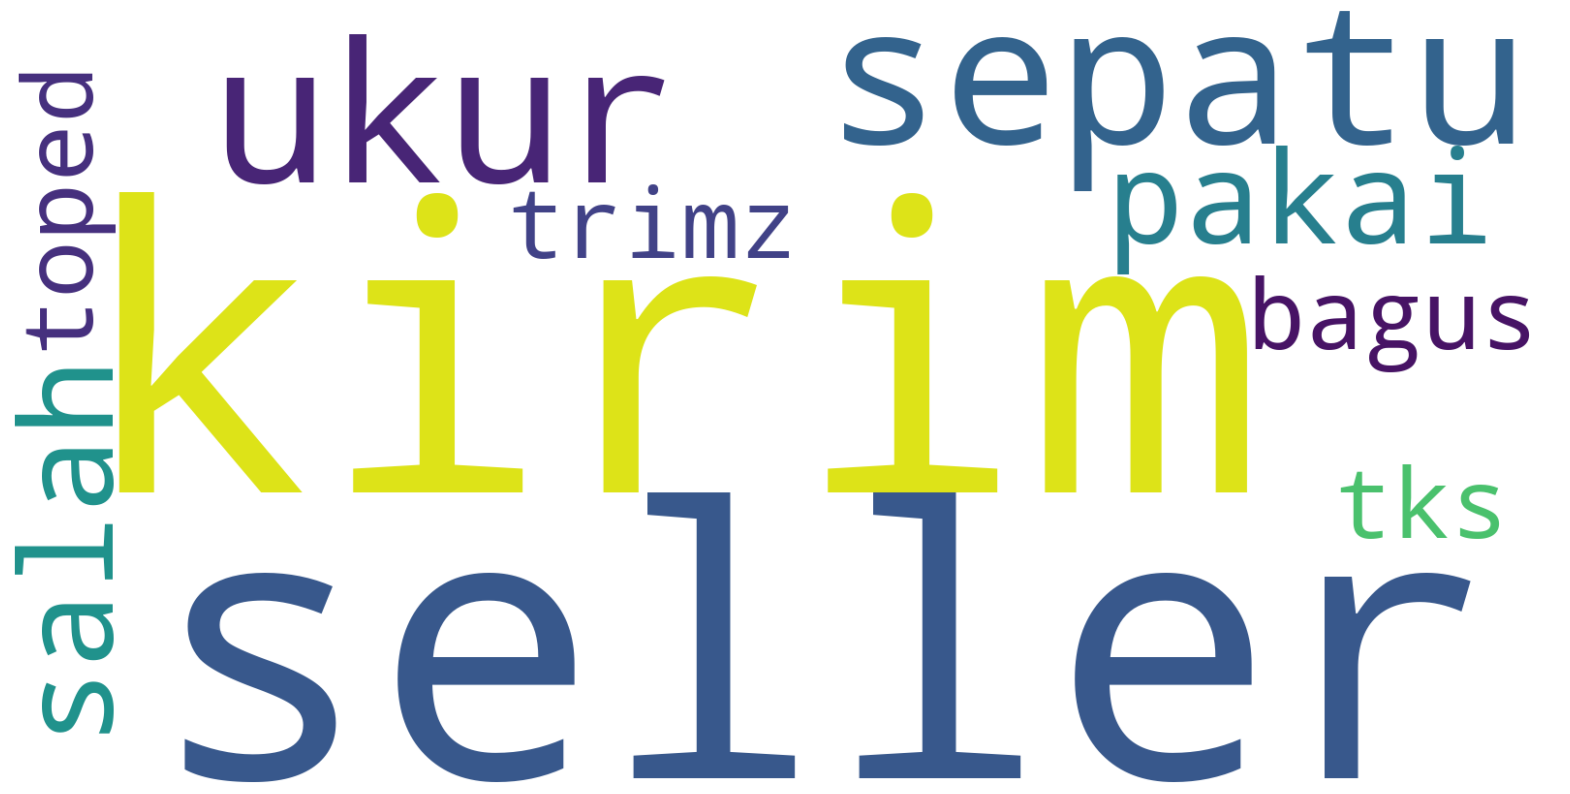

In [27]:
# Filter review_text untuk customer yang tidak merekomendasikan (Sentiment == 0)
negative_reviews = inffinal[inffinal['Sentiment'] == 0]['Review_processed']
# Menggunakan CountVectorizer untuk menghitung frekuensi kata
vectorizer = CountVectorizer(stop_words='english', max_features=10)
X = vectorizer.fit_transform(negative_reviews)
# Mengambil kata-kata dan frekuensi mereka
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))
# Mengurutkan kata-kata berdasarkan frekuensi (dari terbanyak)
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
# Menampilkan 5 kata teratas
top_5_words = sorted_word_freq[:5]
print("Top 5 Words (Negative Reviews):")
for word, freq in top_5_words:
    print(f"{word}: {freq}")
# Jika ingin membuat wordcloud dari 5 kata teratas
top_words_dict = dict(top_5_words)
wc = WordCloud(width=1600, height=800, stopwords=STOPWORDS, background_color='white').generate_from_frequencies(word_freq)
# Menampilkan wordcloud
plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## EDA POSITIVE

Top 5 Words (Positive Reviews):
cepat: 14
barang: 9
sesuai: 9
kirim: 8
seller: 7


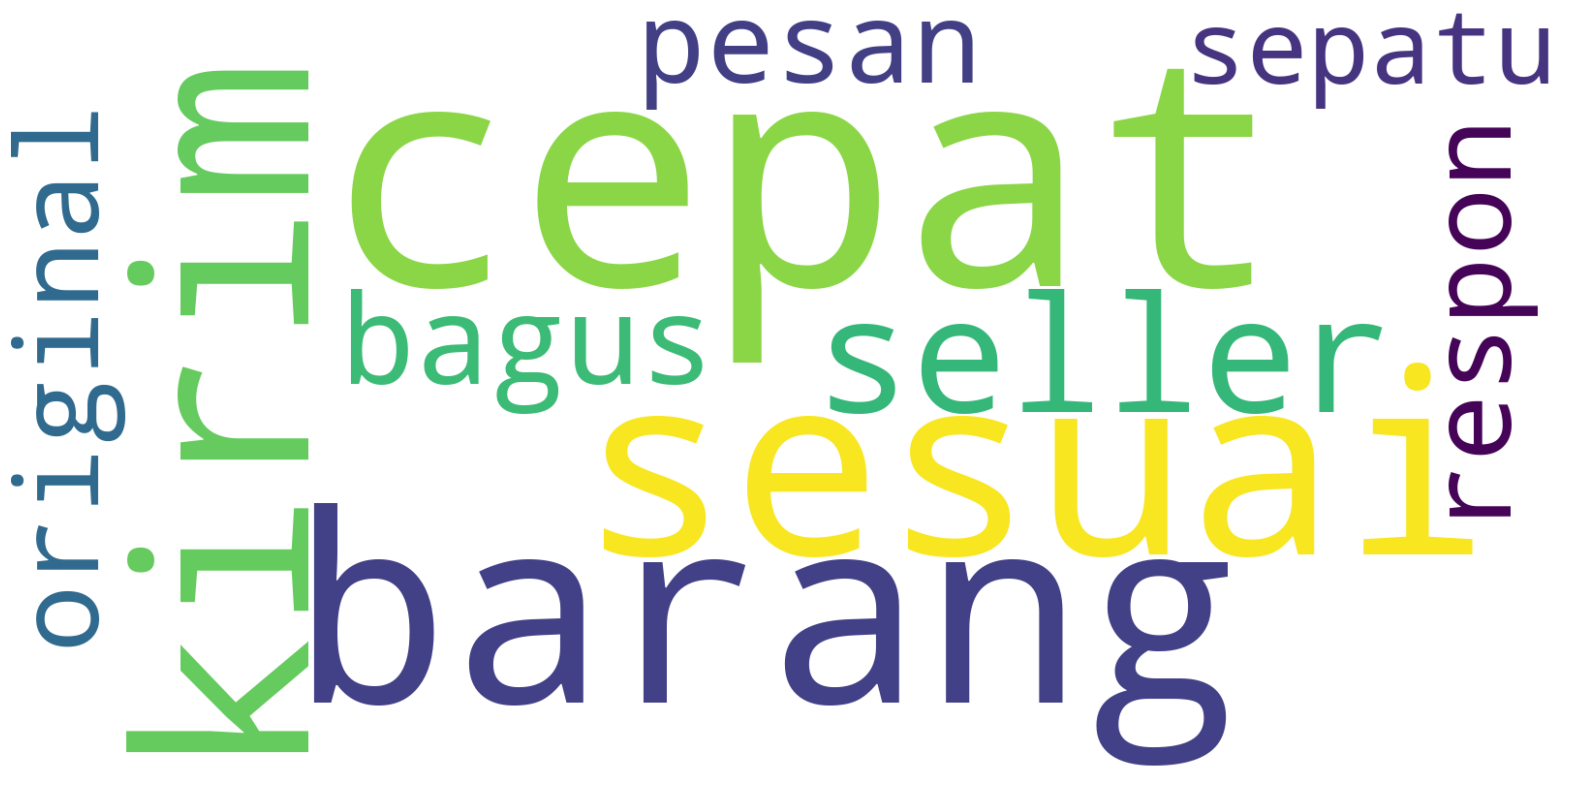

In [28]:
# Filter review_text untuk customer yang merekomendasikan (Sentiment == 1)
positive_reviews = inffinal[inffinal['Sentiment'] == 1]['Review_processed']
# Menggunakan CountVectorizer untuk menghitung frekuensi kata
vectorizer = CountVectorizer(stop_words='english', max_features=10)
X = vectorizer.fit_transform(positive_reviews)
# Mengambil kata-kata dan frekuensi mereka
word_freq = dict(zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0)))
# Mengurutkan kata-kata berdasarkan frekuensi (dari terbanyak)
sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)
# Menampilkan 5 kata teratas
top_5_words = sorted_word_freq[:5]
print("Top 5 Words (Positive Reviews):")
for word, freq in top_5_words:
    print(f"{word}: {freq}")
# Jika ingin membuat wordcloud dari 5 kata teratas
top_words_dict = dict(top_5_words)
wc = WordCloud(width=1600, height=800, stopwords=STOPWORDS, background_color='white').generate_from_frequencies(word_freq)
# Menampilkan wordcloud
plt.figure(figsize=(20, 20))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()